# Imports

In [1]:
import sys
import copy
import numpy as np
from model.base import CovidModel, SimulationParameters, set_parameters, normal_ci
from utils import BasicStatistics, AddPolicy, RemovePolicy, Propaganda, setup_city_layout, AddPolicyInfectedRate, confidence_interval, multiple_runs
from model.utils import SocialPolicy
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import timedelta

## Real Data

### NYTimes Dataset

In [2]:
# os.listdir('./data')
us_counties = pd.read_csv("./data/us-counties.csv")

us_counties.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0


In [3]:
us_counties = us_counties.loc[(us_counties.county == 'Greene') & (us_counties.state == 'Missouri')]
us_counties.index = pd.to_datetime(us_counties['date'])
assert sum(us_counties.fips == 29077.0) == us_counties.shape[0]
us_counties.drop(columns=['county', 'state', 'date', 'fips'], inplace=True)
us_counties.head()

,cases,deaths
date,,
2020-03-12,1,0.0
2020-03-13,1,0.0
2020-03-14,2,0.0
2020-03-15,2,0.0
2020-03-16,3,0.0


<AxesSubplot:xlabel='date'>

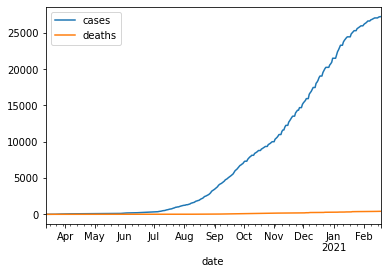

In [4]:
us_counties.plot()

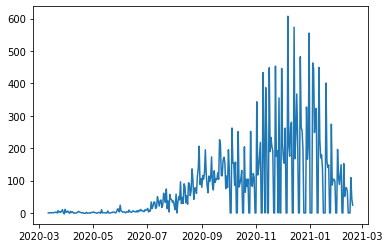

In [5]:
us_counties['daily_cases'] = np.concatenate(([0], us_counties.cases[1:].values - us_counties.cases[:-1].values))
plt.plot(us_counties.daily_cases)

<AxesSubplot:xlabel='date'>

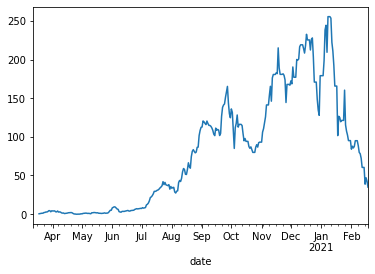

In [6]:
us_counties['mean_daily_cases'] = us_counties['daily_cases'].rolling(7).mean()
us_counties.mean_daily_cases.plot()

In [9]:
us_counties['cases'].tail()

date
2021-02-14    27048
2021-02-15    27048
2021-02-16    27157
2021-02-17    27202
2021-02-18    27226
Name: cases, dtype: int64

# Simulation

## Greene LockDown Parameters

In [7]:
start_date = us_counties.iloc[0]._name

Phase 0: mar 26 - may 3
   - Stay at home order (severe lockdown)
   - Private schools closed
   
Phase 1: may 4 - may 22
   - Either "max 25% occupancy" or "no more than 25 people allowed"
   - Private schools closed

Phase 2: may 23 - jun 14
   - Public gatherings from max 25 people to max 25% occupancy
   - Private schools closed

Phase 3: jun 15 - jul 15
   - Most occupancy limits went to 50%. Public gatherings remained at 25%.
   - Private schools may reopen (assumes public schools are reopened across the state in June)

Phase 3a: jul 16 - oct 11
   - Most occupancy limits went to 50%. Public gatherings remained at 25%.
   - Private schools open

Phase 3b: oct 12 - jan 9 2021
   - Most occupancy limits went to 50% (including public gatherings).
   - Private schools open


In [8]:
s = pd.to_datetime(
    pd.Series(['3/26/2020', 
               '5/4/2020', 
               '5/23/2020', 
               '6/15/2020', 
               '7/16/2020', 
               '10/12/2020', 
               #'1/10/2021'
              ]))

In [9]:
abs_dates = s - start_date
dates_df = pd.DataFrame(s)
dates_df['phase'] = ['0', '1', '2', '3', '3a','3b', 
                     #'4'
                    ]
dates_df['num_days'] = abs_dates.apply(lambda x: int(x.days))
dates_df.columns = ['date', 'phase', 'num_days']

In [10]:
dates_df

,date,phase,num_days
0,2020-03-26,0,14
1,2020-05-04,1,53
2,2020-05-23,2,72
3,2020-06-15,3,95
4,2020-07-16,3a,126
5,2020-10-12,3b,214


In [11]:
START = 0
PHASE_0 = 14
PHASE_1 = 53
PHASE_2 = 72
PHASE_3 = 95
PHASE_3a = 126
PHASE_3b = 214

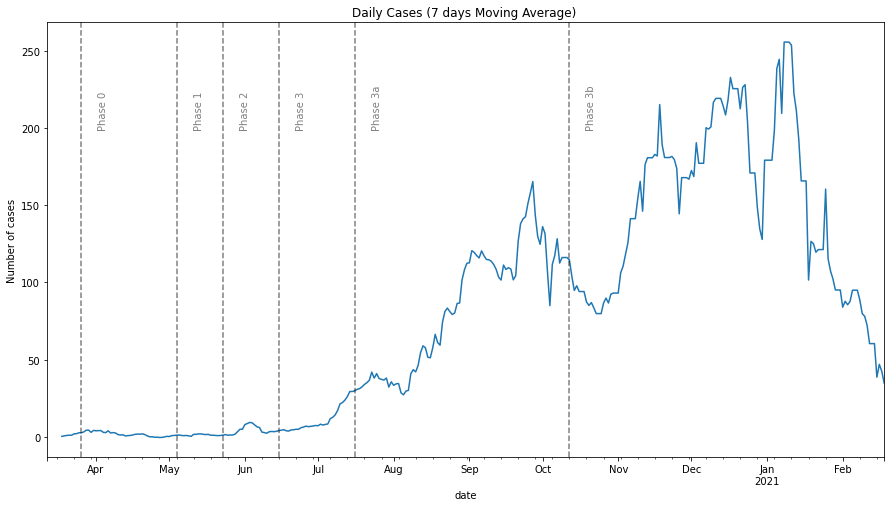

In [12]:
delta = timedelta(days=7)

us_counties.mean_daily_cases.plot(figsize=(15, 8))
plt.title("Daily Cases (7 days Moving Average) ")
plt.ylabel("Number of cases")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 200, 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

In [13]:
us_counties.dropna(inplace=True)
us_counties.index.min()

Timestamp('2020-03-18 00:00:00')

In [14]:
num_days = us_counties.index.max() - us_counties.index.min()
num_days = num_days.days + 1

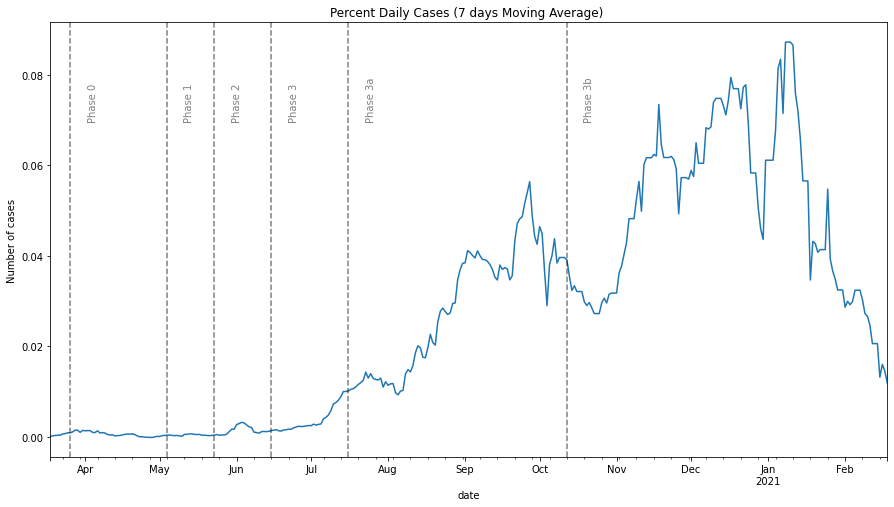

In [15]:
greene_population = 293086

us_counties['percent_daily_cases'] = np.round(100 * us_counties.mean_daily_cases/greene_population, 5)
us_counties['percent_daily_cases'].plot(figsize=(15, 8))
plt.title("Percent Daily Cases (7 days Moving Average) ")
plt.ylabel("Number of cases")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 0.07, 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

## Parameters settings

Até então obtive os melhores resultados de simulação com essas políticas de reabertura abaixo. Nelas estou considerando que ocupação máxima parcial ( 25 ou 50%) ainda é lockdown.  

In [16]:
# Original parameters extracted from Springfield - Greene reopening guidelines
listeners = [
    ["AddPolicy", SocialPolicy.LOCKDOWN_RETAIL, 1],
    ["AddPolicy", SocialPolicy.LOCKDOWN_FACTORY, 1],
    ["AddPolicy", SocialPolicy.LOCKDOWN_OFFICE, 1],
    ["AddPolicy", SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL, 1],
    ["AddPolicy", SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL, 1],
    ["AddPolicy", SocialPolicy.LOCKDOWN_HIGH_SCHOOL, 1],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL, 95],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL, 95],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_HIGH_SCHOOL, 95],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_RETAIL, 214],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_FACTORY, 214],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_OFFICE, 214],
]

I've been trying to replicate results from a real world case

I've collected and processed the data from the county of Greene (in Missouri, US). And extracted from their documents a few reopening guidelines/policies that I tried to replicate in our experiment. 

I haven't gotten nive results up until now, it feels like I have little control over the policies (e.g.: they often reopen stuff with a 25% occupancy limit, which I couldn't replicate). So I'm iterating over the policies and parameters of the simulation to get better results.

Analysis: I might be simulating with too little data... By the time we get to the period in which the real world cases would be rising faster, there's not a lot of susceptible agents in the simulation. 

By the way, since I noticed that the susceptible agents are strictly decreasing, should we take into account that people can be infected more than once and start making them susceptible again? 

In [17]:
listeners = [
    ["AddPolicy", SocialPolicy.LOCKDOWN_RETAIL, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_FACTORY, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_OFFICE, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_HOUSEBOUND, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_HIGH_SCHOOL, START],
    
    
    ["RemovePolicy", SocialPolicy.LOCKDOWN_HOUSEBOUND, PHASE_2],
    
    ["RemovePolicy", SocialPolicy.LOCKDOWN_FACTORY, PHASE_3],
    
    ["RemovePolicy", SocialPolicy.LOCKDOWN_RETAIL, PHASE_3a],
    
#     ["RemovePolicy", SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL, PHASE_3b],
#     ["RemovePolicy", SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL, PHASE_3b],
#     ["RemovePolicy", SocialPolicy.LOCKDOWN_HIGH_SCHOOL, PHASE_3b],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_OFFICE, PHASE_3b],
]

In [18]:
listeners = [
    ["AddPolicy", SocialPolicy.LOCKDOWN_RETAIL, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_FACTORY, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_OFFICE, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_HOUSEBOUND, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_HIGH_SCHOOL, START],
    
    # Reopening guidelines from phase 0 to phase 1 were still very 
    
    ["RemovePolicy", SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL, PHASE_2],
    
    ["RemovePolicy", SocialPolicy.LOCKDOWN_RETAIL, PHASE_3],
#     ["RemovePolicy", SocialPolicy.LOCKDOWN_FACTORY, PHASE_3],

    ["RemovePolicy", SocialPolicy.LOCKDOWN_HOUSEBOUND, PHASE_3a],
    
    ["RemovePolicy", SocialPolicy.LOCKDOWN_OFFICE, PHASE_3b],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL, PHASE_3b],
#     ["RemovePolicy", SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL, PHASE_3b],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_HIGH_SCHOOL, PHASE_3b],
]

In [70]:
listeners = [
    ["AddPolicy", SocialPolicy.LOCKDOWN_RETAIL, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_FACTORY, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_OFFICE, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_HOUSEBOUND, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_HIGH_SCHOOL, START],
    
    ["RemovePolicy", SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL, PHASE_3],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL, PHASE_3],
    
    ["RemovePolicy", SocialPolicy.LOCKDOWN_FACTORY, PHASE_3a],
    
    ["RemovePolicy", SocialPolicy.LOCKDOWN_RETAIL, PHASE_3b],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_OFFICE, PHASE_3b],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_HOUSEBOUND, PHASE_3b],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_HIGH_SCHOOL, PHASE_3b],
]

In [71]:
common_parameters = SimulationParameters(
    mask_user_rate = 0.9,
    mask_efficacy = 0.6,
    imune_rate = 0.01,
    initial_infection_rate = 0.0005,
    hospitalization_capacity = 0.05,
    latency_period_shape = 3,
    latency_period_scale = 1, 
    incubation_period_shape = 6,
    incubation_period_scale = 1, 
    mild_period_duration_shape = 14,
    mild_period_duration_scale = 1,
    hospitalization_period_duration_shape = 12,
    hospitalization_period_duration_scale = 1,
    symptomatic_isolation_rate = 0.0,
    asymptomatic_contagion_probability = 0.1,
#    asymptomatic_contagion_probability = 0.05,
#     risk_tolerance_mean = 0.7,
    risk_tolerance_mean = 0.2,
    risk_tolerance_stdev = 0.2,
    herding_behavior_mean = 0.7,
#    herding_behavior_mean = 0.1,
    herding_behavior_stdev = 0.2,
    allowed_restaurant_capacity = 0.25, #1.0, # valid values: {1.0, 0.50, 0.25}
    spreading_rate = normal_ci(2.41, 3.90, 20)
#    spreading_rate = normal_ci(0.5, 1.5, 20)
)

sc = 10

population_size = 1500
simulation_cycles = num_days # days
seed = 31415
np.random.seed(seed)

params = copy.deepcopy(common_parameters)

In [72]:
greene_demographics = {
    'total_population': 293086,
    'age_distribution':{
        4: 6.0,
        9: 5.7,
        14: 5.8,
        19: 6.5,
        24: 10.6,
        34: 14.1,
        44: 11.7,
        54: 11.5,
        59: 6.0,
        64: 6.0,
        74: 8.9,
        84: 5.0,
        100: 2.1
    },
}

Save these seeds if you want to rerun a scenario
[14568, 31221, 63168, 76414, 65369, 15407, 6812, 85182, 17096, 50499, 5681, 24521, 34752, 91576, 91228, 69453, 2126, 83567, 1565, 14436]
Average similarity between family members is 0.9999358050805562 at temperature -1
Average similarity between family and home is 0.9999295807519797 at temperature -1
Average similarity between students and their classroom is 0.9999149765631956 at temperature -1
Average classroom occupancy is 6.256756756756757 and number classrooms is 74
Average similarity between workers is 0.9999312418277395 at temperature -1
Average office occupancy is 3.860557768924303 and number offices is 251
Average friend similarity for adults: 0.9999180946380916 for kids: 0.9999083108791739
home_districts
[
Home (0,0) district with 30 Buildings
HomogeneousBuilding: 20 units (each with capacity for 5 people.) 17 allocated units with a total of 54 people.
HomogeneousBuilding: 20 units (each with capacity for 5 people.) 20 allocated

avg restaurant similarity 0.9998460936904783
avg restaurant similarity 0.9998767423056972
avg restaurant similarity 0.9998228844297871
avg restaurant similarity 0.9998407015215973
avg restaurant similarity 0.9998667786070327
avg restaurant similarity 0.9998638890436429
avg restaurant similarity 0.9998103505437701
avg restaurant similarity 0.999834157624948
avg restaurant similarity 0.9998497231739533
avg restaurant similarity 0.9998443427501508
avg restaurant similarity 0.9998865341896174
avg restaurant similarity 0.9998320590915851
avg restaurant similarity 0.9997951792240422
avg restaurant similarity 0.99982435356798
avg restaurant similarity 0.9997660915755825
avg restaurant similarity 0.9998225522047234
avg restaurant similarity 0.9997979902864436
avg restaurant similarity 0.9998316015197765
avg restaurant similarity 0.9998813585775653
avg restaurant similarity 0.9997905469829484
avg restaurant similarity 0.9998560513095773
avg restaurant similarity 0.9998490799303117
avg restauran

avg restaurant similarity 0.9999272611163808
avg restaurant similarity 0.9998232723089822
avg restaurant similarity 0.9998234558096372
avg restaurant similarity 0.9998649705537923
avg restaurant similarity 0.999824342033869
avg restaurant similarity 0.9998473871893789
avg restaurant similarity 0.9998439275078433
avg restaurant similarity 0.9998603017263961
avg restaurant similarity 0.9998274044210629
avg restaurant similarity 0.9998787443270895
avg restaurant similarity 0.9998451866333561
avg restaurant similarity 0.9998052916979151
avg restaurant similarity 0.9998771713756588
avg restaurant similarity 0.9998409995454013
avg restaurant similarity 0.9998597301326302
avg restaurant similarity 0.9997895488632257
avg restaurant similarity 0.9998220438577344
avg restaurant similarity 0.999851848945086
avg restaurant similarity 0.9998418370724437
avg restaurant similarity 0.9998686772062104
avg restaurant similarity 0.9999080606475348
avg restaurant similarity 0.9998848071829517
avg restaura

avg restaurant similarity 0.9999050640783631
avg restaurant similarity 0.9999096743753395
avg restaurant similarity 0.9998920249037814
avg restaurant similarity 0.9999102989746992
avg restaurant similarity 0.999900311485849
avg restaurant similarity 0.9998998163943491
avg restaurant similarity 0.9999132323966358
avg restaurant similarity 0.999891683332451
avg restaurant similarity 0.999898966755318
avg restaurant similarity 0.9999144575851491
avg restaurant similarity 0.9999150715198677
avg restaurant similarity 0.9999064705594736
avg restaurant similarity 0.9999004361379052
avg restaurant similarity 0.9999165177650029
avg restaurant similarity 0.9999181738527478
avg restaurant similarity 0.9999102455338514
avg restaurant similarity 0.9998992783558417
avg restaurant similarity 0.9999044727526655
avg restaurant similarity 0.9998982256534097
avg restaurant similarity 0.9998842004250285
avg restaurant similarity 0.999911384340998
avg restaurant similarity 0.9999072572147772
avg restaurant

avg restaurant similarity 0.9998962326261638
avg restaurant similarity 0.9999357766530318
avg restaurant similarity 0.9999130757086024
avg restaurant similarity 0.9999074090743839
avg restaurant similarity 0.9999186192954543
avg restaurant similarity 0.99989426995406
avg restaurant similarity 0.9999199267262208
avg restaurant similarity 0.9998984428414582
avg restaurant similarity 0.9998912078567143
avg restaurant similarity 0.9999198701798463
avg restaurant similarity 0.9999154839135461
avg restaurant similarity 0.9998489887950416
avg restaurant similarity 0.9999202560578462
avg restaurant similarity 0.9998963395814471
avg restaurant similarity 0.9999298811131132
avg restaurant similarity 0.9998798257244434
avg restaurant similarity 0.9999269917539949
avg restaurant similarity 0.999892819143382
avg restaurant similarity 0.99988688229082
avg restaurant similarity 0.9999032971721058
avg restaurant similarity 0.9998993502017349
avg restaurant similarity 0.999863252476752
avg restaurant s

avg restaurant similarity 0.9999150693631724
avg restaurant similarity 0.9998955693743883
avg restaurant similarity 0.9998923774703532
avg restaurant similarity 0.9998993532307654
avg restaurant similarity 0.9999212741471396
avg restaurant similarity 0.9999217641409966
avg restaurant similarity 0.9999118180994493
avg restaurant similarity 0.9999054343075043
avg restaurant similarity 0.9999089261889237
avg restaurant similarity 0.9998904971404953
avg restaurant similarity 0.9999122673287548
avg restaurant similarity 0.9999221604271077
avg restaurant similarity 0.99991600161678
avg restaurant similarity 0.9998991943860782
avg restaurant similarity 0.9998612735218575
avg restaurant similarity 0.9998813383067431
avg restaurant similarity 0.9998825212350287
avg restaurant similarity 0.99991411318867
avg restaurant similarity 0.9998958741721308
avg restaurant similarity 0.9998895266479106
avg restaurant similarity 0.9999136301025646
avg restaurant similarity 0.9999133617450625
avg restaurant

avg restaurant similarity 0.9998988429571771
avg restaurant similarity 0.9998665517699089
avg restaurant similarity 0.9998961890756838
avg restaurant similarity 0.999906370609887
avg restaurant similarity 0.9999170943459044
avg restaurant similarity 0.9998992873230163
avg restaurant similarity 0.9999047797102226
avg restaurant similarity 0.999899628559514
avg restaurant similarity 0.9998087233204651
avg restaurant similarity 0.9999363775269936
avg restaurant similarity 0.9999060071307874
avg restaurant similarity 0.9999246800795617
avg restaurant similarity 0.9999052519551029
avg restaurant similarity 0.9998791086748859
avg restaurant similarity 0.9999330622128094
avg restaurant similarity 0.9998900536937574
avg restaurant similarity 0.9999096555115862
avg restaurant similarity 0.999930735842943
avg restaurant similarity 0.9999016544486187
avg restaurant similarity 0.9998756883974623
avg restaurant similarity 0.9999069527912494
avg restaurant similarity 0.9998707577857622
avg restauran

avg restaurant similarity 0.9997551658287863
avg restaurant similarity 0.9997845406891853
avg restaurant similarity 0.9998036598443019
avg restaurant similarity 0.9997580130250432
avg restaurant similarity 0.999749106897705
avg restaurant similarity 0.9998002424576717
avg restaurant similarity 0.9997409602420038
avg restaurant similarity 0.9997801619777444
avg restaurant similarity 0.9997046867634113
avg restaurant similarity 0.9997243636191862
avg restaurant similarity 0.9996897927758415
avg restaurant similarity 0.9997477311627011
avg restaurant similarity 0.9997838448620926
avg restaurant similarity 0.9997136005656142
avg restaurant similarity 0.9997756609556501
avg restaurant similarity 0.9997586054954984
avg restaurant similarity 0.9998377420931652
avg restaurant similarity 0.9996764483077629
avg restaurant similarity 0.9996417859308823
avg restaurant similarity 0.9997641745661514
avg restaurant similarity 0.9996868911236204
avg restaurant similarity 0.9996810698865499
avg restaur

avg restaurant similarity 0.9997100339916701
avg restaurant similarity 0.9998287552440084
avg restaurant similarity 0.9997531615177824
avg restaurant similarity 0.999683909301481
avg restaurant similarity 0.9998496924457634
avg restaurant similarity 0.9998357202160952
avg restaurant similarity 0.9997740705193844
avg restaurant similarity 0.9997953126975332
avg restaurant similarity 0.9998437484018143
avg restaurant similarity 0.9996567623209838
avg restaurant similarity 0.999745463227245
avg restaurant similarity 0.9998248386993615
avg restaurant similarity 0.9997406756508335
avg restaurant similarity 0.9996848265419696
avg restaurant similarity 0.9998255280464814
avg restaurant similarity 0.9996773614082143
avg restaurant similarity 0.9998727088327419
avg restaurant similarity 0.9996166957877461
avg restaurant similarity 0.9997346826114963
avg restaurant similarity 0.999701546538972
avg restaurant similarity 0.9997487968214088
avg restaurant similarity 0.9998267000459798
avg restauran

avg restaurant similarity 0.9998210529567153
avg restaurant similarity 0.9998098143009169
avg restaurant similarity 0.9997892184305016
avg restaurant similarity 0.9998109885914879
avg restaurant similarity 0.9997946584201198
avg restaurant similarity 0.9998354697327657
avg restaurant similarity 0.9998121433357673
avg restaurant similarity 0.9998133801095442
avg restaurant similarity 0.9997977196729693
avg restaurant similarity 0.9998220249261525
avg restaurant similarity 0.9998616042420962
avg restaurant similarity 0.9998319297334142
avg restaurant similarity 0.9997897093433911
avg restaurant similarity 0.9997566443501608
avg restaurant similarity 0.999809819889588
avg restaurant similarity 0.9998185032149667
avg restaurant similarity 0.9998046901074982
avg restaurant similarity 0.999797905181929
avg restaurant similarity 0.9998183758702184
avg restaurant similarity 0.9998497971521924
avg restaurant similarity 0.9998305974239474
avg restaurant similarity 0.9996799350984177
avg restaura

avg restaurant similarity 0.9997975697707647
avg restaurant similarity 0.9997565533650901
avg restaurant similarity 0.9998409307390898
avg restaurant similarity 0.9997776701656274
avg restaurant similarity 0.9997597434949156
avg restaurant similarity 0.9998084802376886
avg restaurant similarity 0.999874785214967
avg restaurant similarity 0.99983529079142
avg restaurant similarity 0.9998404302785785
avg restaurant similarity 0.9998890983682157
avg restaurant similarity 0.9998419430382761
avg restaurant similarity 0.9998265217282383
avg restaurant similarity 0.999824019284236
avg restaurant similarity 0.9998991133585826
avg restaurant similarity 0.9997694512091365
avg restaurant similarity 0.9997858084250547
avg restaurant similarity 0.9998068864856257
avg restaurant similarity 0.9998360372274765
avg restaurant similarity 0.9998027095544706
avg restaurant similarity 0.9998667606211242
avg restaurant similarity 0.9998295996976929
avg restaurant similarity 0.9998451300506339
avg restaurant

avg restaurant similarity 0.9998593761419965
avg restaurant similarity 0.9998863636466896
avg restaurant similarity 0.9998577609754684
avg restaurant similarity 0.9998675839499254
avg restaurant similarity 0.9998829088652296
avg restaurant similarity 0.9998875214695467
avg restaurant similarity 0.9998620827381863
avg restaurant similarity 0.9998762503975585
avg restaurant similarity 0.9998828514976746
avg restaurant similarity 0.9998379988843359
avg restaurant similarity 0.9998516929782073
avg restaurant similarity 0.9998792033137627
avg restaurant similarity 0.9998510653691713
avg restaurant similarity 0.9998857006887442
avg restaurant similarity 0.9998781414717329
avg restaurant similarity 0.9998420507468309
avg restaurant similarity 0.9998978751927778
avg restaurant similarity 0.9998818779676967
avg restaurant similarity 0.9998587728873143
avg restaurant similarity 0.9998854363431159
avg restaurant similarity 0.9998712061036448
avg restaurant similarity 0.99985278636717
avg restaura

avg restaurant similarity 0.9998765115254244
avg restaurant similarity 0.9998921786790977
avg restaurant similarity 0.9998729205244715
avg restaurant similarity 0.9998521481484317
avg restaurant similarity 0.9998781499142285
avg restaurant similarity 0.9998549679858025
avg restaurant similarity 0.9999000478747595
avg restaurant similarity 0.9998422021119645
avg restaurant similarity 0.9998972790938382
avg restaurant similarity 0.9998685004303031
avg restaurant similarity 0.9998544171151856
avg restaurant similarity 0.9998546471181071
avg restaurant similarity 0.9998733315275133
avg restaurant similarity 0.9998918724599325
avg restaurant similarity 0.9998631846520833
avg restaurant similarity 0.9998911608906839
avg restaurant similarity 0.9998740914454813
avg restaurant similarity 0.9998898952198503
avg restaurant similarity 0.9998935476067601
avg restaurant similarity 0.9998663780352894
avg restaurant similarity 0.9998447306074687
avg restaurant similarity 0.9998648081927702
avg restau

avg restaurant similarity 0.9995804390447651
avg restaurant similarity 0.9996453418437582
avg restaurant similarity 0.9996249680938174
avg restaurant similarity 0.9996133848166665
avg restaurant similarity 0.9995957837565954
avg restaurant similarity 0.999647718895209
avg restaurant similarity 0.9996120847091325
avg restaurant similarity 0.999603223249169
avg restaurant similarity 0.9995537731689441
avg restaurant similarity 0.9995610207525779
avg restaurant similarity 0.999653205747064
avg restaurant similarity 0.9995870720131467
avg restaurant similarity 0.9996916997939156
avg restaurant similarity 0.9995992141736372
avg restaurant similarity 0.9996198209131195
avg restaurant similarity 0.999330845996667
avg restaurant similarity 0.999628882835529
avg restaurant similarity 0.9995990061311997
avg restaurant similarity 0.9995438204866622
avg restaurant similarity 0.9996103989140105
avg restaurant similarity 0.9995791986767466
avg restaurant similarity 0.9996242677813271
avg restaurant 

avg restaurant similarity 0.9995591427991509
avg restaurant similarity 0.9996370873651702
avg restaurant similarity 0.9996275436373887
avg restaurant similarity 0.9997330134306005
avg restaurant similarity 0.999589583088683
avg restaurant similarity 0.9995899465784068
avg restaurant similarity 0.9996383763952749
avg restaurant similarity 0.9996077023552111
avg restaurant similarity 0.9995696808187416
avg restaurant similarity 0.999607197606428
avg restaurant similarity 0.9996215874452743
avg restaurant similarity 0.9996243342215411
avg restaurant similarity 0.9996345465404626
avg restaurant similarity 0.9996197276047808
avg restaurant similarity 0.9996216229101292
avg restaurant similarity 0.9995820426185865
avg restaurant similarity 0.9996967075362242
avg restaurant similarity 0.9995954543219833
avg restaurant similarity 0.9996224937897187
avg restaurant similarity 0.9997547975858025
avg restaurant similarity 0.9995720404817495
avg restaurant similarity 0.9994910692656309
avg restaura

avg restaurant similarity 0.9998022685921054
avg restaurant similarity 0.9998822502945829
avg restaurant similarity 0.9998640035138002
avg restaurant similarity 0.999833035594761
avg restaurant similarity 0.9998663960087177
avg restaurant similarity 0.9998807793234634
avg restaurant similarity 0.9998603186289874
avg restaurant similarity 0.9998839165346282
avg restaurant similarity 0.9998954305605462
avg restaurant similarity 0.9998625192231945
avg restaurant similarity 0.9998670238698695
avg restaurant similarity 0.9998688161319097
avg restaurant similarity 0.9998702814145751
avg restaurant similarity 0.99984444014219
avg restaurant similarity 0.9998927018363459
avg restaurant similarity 0.9998835938053976
avg restaurant similarity 0.999913822542716
avg restaurant similarity 0.9998817007687194
avg restaurant similarity 0.9998691232887826
avg restaurant similarity 0.9998224128137639
avg restaurant similarity 0.9998693191690636
avg restaurant similarity 0.9998861494340953
avg restaurant

avg restaurant similarity 0.9998922165639079
avg restaurant similarity 0.9998471878755223
avg restaurant similarity 0.999871849712821
avg restaurant similarity 0.9998597968288834
avg restaurant similarity 0.9998624298986345
avg restaurant similarity 0.999858094108377
avg restaurant similarity 0.9998738284131167
avg restaurant similarity 0.9998672977686277
avg restaurant similarity 0.9998510062709048
avg restaurant similarity 0.9998412161113507
avg restaurant similarity 0.9998757979459554
avg restaurant similarity 0.9998333454238251
avg restaurant similarity 0.9998596854518824
avg restaurant similarity 0.9998866639377264
avg restaurant similarity 0.9998040969537194
avg restaurant similarity 0.9998836213408206
avg restaurant similarity 0.9998172017456054
avg restaurant similarity 0.9998565843455761
avg restaurant similarity 0.9998406347302571
avg restaurant similarity 0.9998460351579652
avg restaurant similarity 0.9998757979459554
avg restaurant similarity 0.9998730709960326
avg restaura

avg restaurant similarity 0.999892795171354
avg restaurant similarity 0.999904395595721
avg restaurant similarity 0.9998620616251834
avg restaurant similarity 0.9998932970673293
avg restaurant similarity 0.9998870529792384
avg restaurant similarity 0.99990498806716
avg restaurant similarity 0.9998884590610254
avg restaurant similarity 0.9998586190048465
avg restaurant similarity 0.9998945289819112
avg restaurant similarity 0.9998958305025426
avg restaurant similarity 0.9999174632284296
avg restaurant similarity 0.9998646671256024
avg restaurant similarity 0.9998586700181308
avg restaurant similarity 0.9998574121945228
avg restaurant similarity 0.9998848273189168
avg restaurant similarity 0.9998680595536443
avg restaurant similarity 0.9999115443985165
avg restaurant similarity 0.9998859066528235
avg restaurant similarity 0.9998899464905279
avg restaurant similarity 0.9998898891467126
avg restaurant similarity 0.9999116140911813
avg restaurant similarity 0.9998742115660502
avg restaurant

avg restaurant similarity 0.9998654299507139
avg restaurant similarity 0.9998997608165224
avg restaurant similarity 0.9999051270444157
avg restaurant similarity 0.9998858501173964
avg restaurant similarity 0.999884120218918
avg restaurant similarity 0.9998770169491685
avg restaurant similarity 0.9998387897417512
avg restaurant similarity 0.9998933453472537
avg restaurant similarity 0.9998970102425973
avg restaurant similarity 0.9998714532894377
avg restaurant similarity 0.9998625270568263
avg restaurant similarity 0.999897492630525
avg restaurant similarity 0.9999176549464585
avg restaurant similarity 0.9999163754253874
avg restaurant similarity 0.9998647880392941
avg restaurant similarity 0.9998625226116173
avg restaurant similarity 0.999843881788218
avg restaurant similarity 0.9999021358191881
avg restaurant similarity 0.9998740837357006
avg restaurant similarity 0.9998672183071877
avg restaurant similarity 0.999916240696205
avg restaurant similarity 0.9999141682611074
avg restaurant

avg restaurant similarity 0.999814372788216
avg restaurant similarity 0.999862768835853
avg restaurant similarity 0.9998681467820577
avg restaurant similarity 0.9998790635077035
avg restaurant similarity 0.9998635927805635
avg restaurant similarity 0.9998922590101497
avg restaurant similarity 0.999864396424366
avg restaurant similarity 0.9998949977612811
avg restaurant similarity 0.9998573013259292
avg restaurant similarity 0.9998760779187085
avg restaurant similarity 0.9998553270485425
avg restaurant similarity 0.9998473878570916
avg restaurant similarity 0.9998803371773911
avg restaurant similarity 0.9998512786411574
avg restaurant similarity 0.9998660363631942
avg restaurant similarity 0.9998488053674291
avg restaurant similarity 0.9998770829758566
avg restaurant similarity 0.999872520338986
avg restaurant similarity 0.9998540490407982
avg restaurant similarity 0.9998772401107436
avg restaurant similarity 0.9998702111698456
avg restaurant similarity 0.9998622231680553
avg restaurant

avg restaurant similarity 0.9998464089937249
avg restaurant similarity 0.9998633035582146
avg restaurant similarity 0.9998591522024043
avg restaurant similarity 0.9998701336539152
avg restaurant similarity 0.9998833531428118
avg restaurant similarity 0.9998817008416534
avg restaurant similarity 0.9998897928381172
avg restaurant similarity 0.9998623494054848
avg restaurant similarity 0.9998593349949927
avg restaurant similarity 0.9998443845821545
avg restaurant similarity 0.9999101460856499
avg restaurant similarity 0.999886280665555
avg restaurant similarity 0.9998890193836907
avg restaurant similarity 0.9998380706429972
avg restaurant similarity 0.9998726758950868
avg restaurant similarity 0.9998899309765661
avg restaurant similarity 0.9998682922904675
avg restaurant similarity 0.9998627768957221
avg restaurant similarity 0.9998819439390211
avg restaurant similarity 0.9998793467386895
avg restaurant similarity 0.999875525497416
avg restaurant similarity 0.9998972442584846
avg restaura

avg restaurant similarity 0.9998580965829285
avg restaurant similarity 0.999750105644227
avg restaurant similarity 0.9997871585153342
avg restaurant similarity 0.9997777759146539
avg restaurant similarity 0.9996768022037396
avg restaurant similarity 0.9998497326304756
avg restaurant similarity 0.9997263342462326
avg restaurant similarity 0.9997245722131624
avg restaurant similarity 0.999726235717469
avg restaurant similarity 0.9998041706856605
avg restaurant similarity 0.9997877753895883
avg restaurant similarity 0.9998021283892453
avg restaurant similarity 0.9997680780462496
avg restaurant similarity 0.9998352756274164
avg restaurant similarity 0.9997551933870091
avg restaurant similarity 0.9998257053019712
avg restaurant similarity 0.9998351868116532
avg restaurant similarity 0.9998053910317238
avg restaurant similarity 0.9997779643995428
avg restaurant similarity 0.9996173748831618
avg restaurant similarity 0.999831010206958
avg restaurant similarity 0.9997923351137459
avg restauran

avg restaurant similarity 0.9997719407615961
avg restaurant similarity 0.999777517804194
avg restaurant similarity 0.9997865284272657
avg restaurant similarity 0.9998537597550785
avg restaurant similarity 0.9999014390552656
avg restaurant similarity 0.999751569253577
avg restaurant similarity 0.999775025822343
avg restaurant similarity 0.9997976175228507
avg restaurant similarity 0.9997324224633797
avg restaurant similarity 0.9998111595476197
avg restaurant similarity 0.9998125219574922
avg restaurant similarity 0.9998924925942118
avg restaurant similarity 0.9998007380504793
avg restaurant similarity 0.9996811923716359
avg restaurant similarity 0.9997869675586109
avg restaurant similarity 0.9997533695211384
avg restaurant similarity 0.9996933490324355
avg restaurant similarity 0.9997447102943221
avg restaurant similarity 0.9997221773428601
avg restaurant similarity 0.9998409469337155
avg restaurant similarity 0.999698605806722
avg restaurant similarity 0.999762613142861
avg restaurant 

avg restaurant similarity 0.9998702083145213
avg restaurant similarity 0.9998365037988418
avg restaurant similarity 0.9998175422720396
avg restaurant similarity 0.9998838437795851
avg restaurant similarity 0.999881089932923
avg restaurant similarity 0.9998326538773351
avg restaurant similarity 0.9998520783939848
avg restaurant similarity 0.9998046557053287
avg restaurant similarity 0.9998332643352394
avg restaurant similarity 0.999859537660364
avg restaurant similarity 0.9997871204629037
avg restaurant similarity 0.9998372891239898
avg restaurant similarity 0.999841671819485
avg restaurant similarity 0.9998115281851995
avg restaurant similarity 0.9998203359494938
avg restaurant similarity 0.9998664937628372
avg restaurant similarity 0.9998229281942097
avg restaurant similarity 0.9998595787125044
avg restaurant similarity 0.9998420421376756
avg restaurant similarity 0.9998314245072625
avg restaurant similarity 0.9998637648327757
avg restaurant similarity 0.9998461196223483
avg restauran

avg restaurant similarity 0.9998391499072596
avg restaurant similarity 0.9997848225436605
avg restaurant similarity 0.9998360211272462
avg restaurant similarity 0.9998451433558804
avg restaurant similarity 0.9998834481099143
avg restaurant similarity 0.999847541515781
avg restaurant similarity 0.9998335975960163
avg restaurant similarity 0.9998228829931568
avg restaurant similarity 0.9998416232830931
avg restaurant similarity 0.9998652268556599
avg restaurant similarity 0.9998372176050618
avg restaurant similarity 0.9998516469127139
avg restaurant similarity 0.999779573364443
avg restaurant similarity 0.9999051240445422
avg restaurant similarity 0.999815276921515
avg restaurant similarity 0.9998444435741853
avg restaurant similarity 0.9998525030162446
avg restaurant similarity 0.99983241850361
avg restaurant similarity 0.9998808265002848
avg restaurant similarity 0.9997158367471077
avg restaurant similarity 0.9998417554790132
avg restaurant similarity 0.9998440857092165
avg restaurant 

avg restaurant similarity 0.999901223923462
avg restaurant similarity 0.9998600891145789
avg restaurant similarity 0.9999045891197026
avg restaurant similarity 0.9998935952251223
avg restaurant similarity 0.9998761245940394
avg restaurant similarity 0.9998380739778199
avg restaurant similarity 0.9998656914469307
avg restaurant similarity 0.9998845994125534
avg restaurant similarity 0.999854225660491
avg restaurant similarity 0.9998638461255113
avg restaurant similarity 0.9999016817651258
avg restaurant similarity 0.9998435144910133
avg restaurant similarity 0.9998848319022395
avg restaurant similarity 0.9998898769843446
avg restaurant similarity 0.9998811909427331
avg restaurant similarity 0.9998700884930477
avg restaurant similarity 0.9998792127356021
avg restaurant similarity 0.9998694508501623
avg restaurant similarity 0.9998818879528546
avg restaurant similarity 0.9998551699985914
avg restaurant similarity 0.9998663706921697
avg restaurant similarity 0.9998558909353271
avg restaura

avg restaurant similarity 0.9998574916836741
avg restaurant similarity 0.9999031262727929
avg restaurant similarity 0.9998769483524125
avg restaurant similarity 0.9998800352118017
avg restaurant similarity 0.9998913319791268
avg restaurant similarity 0.9999152508275052
avg restaurant similarity 0.9999097535682774
avg restaurant similarity 0.9998179803717174
avg restaurant similarity 0.9998509784965054
avg restaurant similarity 0.9998759058893497
avg restaurant similarity 0.999892400739137
avg restaurant similarity 0.9998693505869475
avg restaurant similarity 0.9998794948166351
avg restaurant similarity 0.9998492245949763
avg restaurant similarity 0.9998686753631303
avg restaurant similarity 0.9998238661743674
avg restaurant similarity 0.999899976759892
avg restaurant similarity 0.9998709038756404
avg restaurant similarity 0.9998698756277793
avg restaurant similarity 0.9999300782219332
avg restaurant similarity 0.9998997868464409
avg restaurant similarity 0.9998603896596251
avg restaura

avg restaurant similarity 0.9999075143493098
avg restaurant similarity 0.9998731810128721
avg restaurant similarity 0.9999027928814741
avg restaurant similarity 0.9998309154347891
avg restaurant similarity 0.9999194701907712
avg restaurant similarity 0.9998971399674067
avg restaurant similarity 0.9998867762520677
avg restaurant similarity 0.9998888120363452
avg restaurant similarity 0.9998918145280092
avg restaurant similarity 0.9999228448725835
avg restaurant similarity 0.9998950151926941
avg restaurant similarity 0.9999112178316
avg restaurant similarity 0.9999044209470653
avg restaurant similarity 0.999902249553997
avg restaurant similarity 0.9999050082457519
avg restaurant similarity 0.9999361531525046
avg restaurant similarity 0.9999308941253754
avg restaurant similarity 0.9999049083169762
avg restaurant similarity 0.9998832750133375
avg restaurant similarity 0.9998610752588805
avg restaurant similarity 0.9998776527106564
avg restaurant similarity 0.9999148695919328
avg restaurant

avg restaurant similarity 0.9999069455113629
avg restaurant similarity 0.999906772576964
avg restaurant similarity 0.9998427573303209
avg restaurant similarity 0.99989560755531
avg restaurant similarity 0.9999013746930333
avg restaurant similarity 0.9999359357762221
avg restaurant similarity 0.9999096224637547
avg restaurant similarity 0.9998855962295572
avg restaurant similarity 0.999911070867996
avg restaurant similarity 0.9998453946575835
avg restaurant similarity 0.9999064953293116
avg restaurant similarity 0.9999037478851422
avg restaurant similarity 0.9998691289558084
avg restaurant similarity 0.9998993495341763
avg restaurant similarity 0.999819217466803
avg restaurant similarity 0.999899207028435
avg restaurant similarity 0.9997628954878472
avg restaurant similarity 0.9999139044285529
avg restaurant similarity 0.9998912476106165
avg restaurant similarity 0.9998929816897395
avg restaurant similarity 0.9998596802798639
avg restaurant similarity 0.9999720932966365
avg restaurant s

avg restaurant similarity 0.9998680647888264
avg restaurant similarity 0.9998876815856107
avg restaurant similarity 0.9998621302147566
avg restaurant similarity 0.9998703533765977
avg restaurant similarity 0.9998683291546034
avg restaurant similarity 0.999902059082682
avg restaurant similarity 0.9998052149340513
avg restaurant similarity 0.9998972214087007
avg restaurant similarity 0.9999081097829781
avg restaurant similarity 0.9998782930983415
avg restaurant similarity 0.9998647100753008
avg restaurant similarity 0.9998567969847861
avg restaurant similarity 0.9998404065214164
avg restaurant similarity 0.9998741589271593
avg restaurant similarity 0.999896739570973
avg restaurant similarity 0.9998686383542158
avg restaurant similarity 0.9998408954499771
avg restaurant similarity 0.9998856406994704
avg restaurant similarity 0.9998738109528502
avg restaurant similarity 0.9999096355353235
avg restaurant similarity 0.9998782346752713
avg restaurant similarity 0.9998548173129678
avg restaura

avg restaurant similarity 0.9998983213492699
avg restaurant similarity 0.9998898721627917
avg restaurant similarity 0.9998753524014685
avg restaurant similarity 0.9998413401509578
avg restaurant similarity 0.9999119536297754
avg restaurant similarity 0.9998781190531786
avg restaurant similarity 0.999925780962909
avg restaurant similarity 0.9998328624194175
avg restaurant similarity 0.9998803209018968
avg restaurant similarity 0.9998578727114733
avg restaurant similarity 0.999919306640096
avg restaurant similarity 0.9998940039650812
avg restaurant similarity 0.9998906266937047
avg restaurant similarity 0.9998824815594184
avg restaurant similarity 0.9998495664776572
avg restaurant similarity 0.9998965959949206
avg restaurant similarity 0.9999161037198965
avg restaurant similarity 0.9998925764299055
avg restaurant similarity 0.9998858019510882
avg restaurant similarity 0.9999033945009184
avg restaurant similarity 0.9998727942572463
avg restaurant similarity 0.9998998874766575
avg restaura

avg restaurant similarity 0.999812787646861
avg restaurant similarity 0.9998866530299828
avg restaurant similarity 0.9998215709235875
avg restaurant similarity 0.999750335828843
avg restaurant similarity 0.9999102881015307
avg restaurant similarity 0.9998472497188682
avg restaurant similarity 0.9999155239109417
avg restaurant similarity 0.9999028286168665
avg restaurant similarity 0.9998888949149949
avg restaurant similarity 0.9999102085661402
avg restaurant similarity 0.9998768931236
avg restaurant similarity 0.9998451273544333
avg restaurant similarity 0.9999329726046746
avg restaurant similarity 0.9998771531877352
avg restaurant similarity 0.9998672366324374
avg restaurant similarity 0.9998104842583879
avg restaurant similarity 0.9998536834856853
avg restaurant similarity 0.9998088405902804
avg restaurant similarity 0.999858778704582
avg restaurant similarity 0.999853890770143
avg restaurant similarity 0.9998357095584439
avg restaurant similarity 0.9999198256613282
avg restaurant si

avg restaurant similarity 0.9999071816407238
avg restaurant similarity 0.9998142458782384
avg restaurant similarity 0.9998733617576399
avg restaurant similarity 0.9998813396916802
avg restaurant similarity 0.9998493241008894
avg restaurant similarity 0.9998792702601176
avg restaurant similarity 0.9998950847201797
avg restaurant similarity 0.9998731478267149
avg restaurant similarity 0.999778483405159
avg restaurant similarity 0.9998552873439511
avg restaurant similarity 0.9998642658379312
avg restaurant similarity 0.9998780268292151
avg restaurant similarity 0.9998792539680856
avg restaurant similarity 0.999898935502444
avg restaurant similarity 0.9998282543985063
avg restaurant similarity 0.9998532713759012
avg restaurant similarity 0.9998683030769088
avg restaurant similarity 0.9998381830320658
avg restaurant similarity 0.9999119996073258
avg restaurant similarity 0.9999232393103498
avg restaurant similarity 0.999873128446772
avg restaurant similarity 0.9998739963218954
avg restauran

avg restaurant similarity 0.9998098764718513
avg restaurant similarity 0.9997858509770917
avg restaurant similarity 0.9997777254726681
avg restaurant similarity 0.9998117862637443
avg restaurant similarity 0.9998442955534403
avg restaurant similarity 0.9998272253574044
avg restaurant similarity 0.9998073649128489
avg restaurant similarity 0.999823846547772
avg restaurant similarity 0.9998151474626358
avg restaurant similarity 0.9998359833476291
avg restaurant similarity 0.9998059389783703
avg restaurant similarity 0.9998075403197836
avg restaurant similarity 0.9998012485552469
avg restaurant similarity 0.9998177516275073
avg restaurant similarity 0.9997754911435587
avg restaurant similarity 0.9997813776258687
avg restaurant similarity 0.9998334577664374
avg restaurant similarity 0.9998403686563342
avg restaurant similarity 0.9998156750535094
avg restaurant similarity 0.9997969425640897
avg restaurant similarity 0.9998405141536669
avg restaurant similarity 0.9997767040078172
avg restaur

avg restaurant similarity 0.9997974263429906
avg restaurant similarity 0.999760218725941
avg restaurant similarity 0.9997948173917969
avg restaurant similarity 0.9997974362160762
avg restaurant similarity 0.9998311854990369
avg restaurant similarity 0.9998814916876088
avg restaurant similarity 0.999802473127349
avg restaurant similarity 0.9998282705276144
avg restaurant similarity 0.9998219647164152
avg restaurant similarity 0.9997982192838745
avg restaurant similarity 0.9998143937588327
avg restaurant similarity 0.9998434179998474
avg restaurant similarity 0.9997703158598462
avg restaurant similarity 0.9997424287796024
avg restaurant similarity 0.999826573992601
avg restaurant similarity 0.9998006981770732
avg restaurant similarity 0.9998245073853421
avg restaurant similarity 0.9998202005332042
avg restaurant similarity 0.9998153828840416
avg restaurant similarity 0.9998370651158746
avg restaurant similarity 0.9997686336591676
avg restaurant similarity 0.999786278736152
avg restaurant

avg restaurant similarity 0.9998421209701259
avg restaurant similarity 0.9998695608791276
avg restaurant similarity 0.9998521743582511
avg restaurant similarity 0.9998568224847505
avg restaurant similarity 0.9998895656110026
avg restaurant similarity 0.9998632232131888
avg restaurant similarity 0.9998588204387721
avg restaurant similarity 0.9998700756234336
avg restaurant similarity 0.999860509769403
avg restaurant similarity 0.999863619419085
avg restaurant similarity 0.9998560375173597
avg restaurant similarity 0.9998574740448974
avg restaurant similarity 0.9998556854794199
avg restaurant similarity 0.9998550571682379
avg restaurant similarity 0.9998454723447037
avg restaurant similarity 0.9998772109828378
avg restaurant similarity 0.9998601092473542
avg restaurant similarity 0.9998785672368259
avg restaurant similarity 0.9998662978673053
avg restaurant similarity 0.9998662622842577
avg restaurant similarity 0.9998907915035359
avg restaurant similarity 0.9998625505442194
avg restaura

avg restaurant similarity 0.9998327993264465
avg restaurant similarity 0.99982842788704
avg restaurant similarity 0.99986554405447
avg restaurant similarity 0.9998560306732114
avg restaurant similarity 0.9998312695863805
avg restaurant similarity 0.9997907972005105
avg restaurant similarity 0.9998781482285541
avg restaurant similarity 0.9998528372746438
avg restaurant similarity 0.9998322465617114
avg restaurant similarity 0.9998573901916854
avg restaurant similarity 0.9998318709526518
avg restaurant similarity 0.9998853059047906
avg restaurant similarity 0.9998588031009464
avg restaurant similarity 0.9998922814646103
avg restaurant similarity 0.999853812775314
avg restaurant similarity 0.9998733817167795
avg restaurant similarity 0.9998449725999948
avg restaurant similarity 0.9998825380907548
avg restaurant similarity 0.9998700841631525
avg restaurant similarity 0.9998941917577723
avg restaurant similarity 0.9998659985903289
avg restaurant similarity 0.9998811196250889
avg restaurant 

avg restaurant similarity 0.9997850445838027
avg restaurant similarity 0.9998199784104137
avg restaurant similarity 0.999869592436616
avg restaurant similarity 0.9998289402841976
avg restaurant similarity 0.9997766768027311
avg restaurant similarity 0.9998939261792839
avg restaurant similarity 0.99982567108439
avg restaurant similarity 0.9998652437722086
avg restaurant similarity 0.9997972211316687
avg restaurant similarity 0.9997745132587116
avg restaurant similarity 0.9998434167573811
avg restaurant similarity 0.9997950484434394
avg restaurant similarity 0.9997525647147059
avg restaurant similarity 0.9997825766182362
avg restaurant similarity 0.9997922136813391
avg restaurant similarity 0.9997936829097354
avg restaurant similarity 0.9997746422399277
avg restaurant similarity 0.9997981589555099
avg restaurant similarity 0.9997103665397344
avg restaurant similarity 0.9998264838180103
avg restaurant similarity 0.9996818234008028
avg restaurant similarity 0.9998479292831438
avg restauran

avg restaurant similarity 0.9997943983007455
avg restaurant similarity 0.9997847604214295
avg restaurant similarity 0.9998367032400727
avg restaurant similarity 0.9996738205487979
avg restaurant similarity 0.999744923435428
avg restaurant similarity 0.9998105907703103
avg restaurant similarity 0.999775666122499
avg restaurant similarity 0.999818690094853
avg restaurant similarity 0.9998130975288738
avg restaurant similarity 0.9998557295845849
avg restaurant similarity 0.9997790711687211
avg restaurant similarity 0.9998291043574316
avg restaurant similarity 0.999764184366747
avg restaurant similarity 0.9996660180639492
avg restaurant similarity 0.9998678716357285
avg restaurant similarity 0.9998434543849705
avg restaurant similarity 0.9997721770657246
avg restaurant similarity 0.9998358599112181
avg restaurant similarity 0.9998584192221364
avg restaurant similarity 0.9998115710368265
avg restaurant similarity 0.9999262700824877
avg restaurant similarity 0.9998385230743239
avg restaurant

avg restaurant similarity 0.9998394705769652
avg restaurant similarity 0.9998417091299086
avg restaurant similarity 0.999836991243493
avg restaurant similarity 0.9998286999884607
avg restaurant similarity 0.999808591567335
avg restaurant similarity 0.9998251713060023
avg restaurant similarity 0.9998295033445839
avg restaurant similarity 0.9998073414522467
avg restaurant similarity 0.999859876377888
avg restaurant similarity 0.9998834661890698
avg restaurant similarity 0.9998294632137626
avg restaurant similarity 0.9998434259429619
avg restaurant similarity 0.9998173551110529
avg restaurant similarity 0.9998384734486926
avg restaurant similarity 0.9998313898629309
avg restaurant similarity 0.9998713181592992
avg restaurant similarity 0.999847204105348
avg restaurant similarity 0.9998478234866723
avg restaurant similarity 0.9998560947562327
avg restaurant similarity 0.9998453271188296
avg restaurant similarity 0.9998387501597097
avg restaurant similarity 0.9998690712048233
avg restaurant

avg restaurant similarity 0.9998371947639937
avg restaurant similarity 0.9998484848597742
avg restaurant similarity 0.9998368308785919
avg restaurant similarity 0.9998570414690579
avg restaurant similarity 0.9998409116856924
avg restaurant similarity 0.9998509016964456
avg restaurant similarity 0.999841320277058
avg restaurant similarity 0.9999733937092056
avg restaurant similarity 0.9998465862430391
avg restaurant similarity 0.9998382821030475
avg restaurant similarity 0.9998218589711367
avg restaurant similarity 0.9998585512653622
avg restaurant similarity 0.9998641464981857
avg restaurant similarity 0.9998186845232166
avg restaurant similarity 0.9998680454415394
avg restaurant similarity 0.999833570555423
avg restaurant similarity 0.9998332683247222
avg restaurant similarity 0.9998330729601792
avg restaurant similarity 0.999829088486392
avg restaurant similarity 0.9998610081791797
avg restaurant similarity 0.9997795114465675
avg restaurant similarity 0.9998676137691359
avg restauran

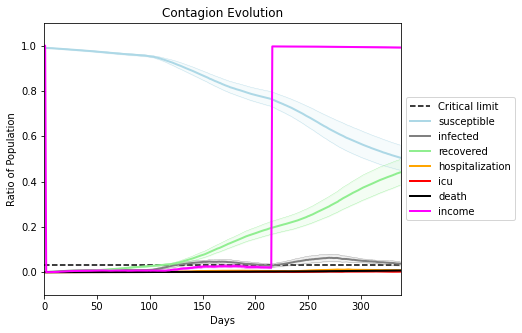

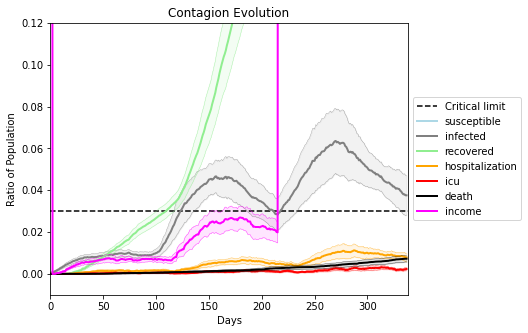

In [78]:
import logging
def setLevel(level):
    logger1 = logging.getLogger()
    logger1.setLevel(level)

seeds = [9675]
seeds = [14568, 31221, 63168, 76414, 65369, 15407,  6812, 85182, 17096,
         50499,  5681, 24521, 34752, 91576, 91228, 69453,  2126, 83567,
         1565, 14436]
setLevel(logging.CRITICAL)
lower, average, upper, color, statistics, avg,  last,  peak = multiple_runs(
    params,
    population_size,
    simulation_cycles,
    seeds = seeds,
    fname = "ramon",
    do_print = True, 
    desired_stats = ["susceptible", "infected", "recovered", "hospitalization", "icu", "death", "income"],
    listeners = listeners,
    demographics = greene_demographics
)

In [79]:
infected_df = pd.DataFrame(
    {'lower': lower['infected'],
    'average': average['infected'],
    'upper': upper['infected']}
)
infected_df.index = us_counties.index

Text(2021-01-01 00:00:00, 0.07120596936925006, 'Christmas')

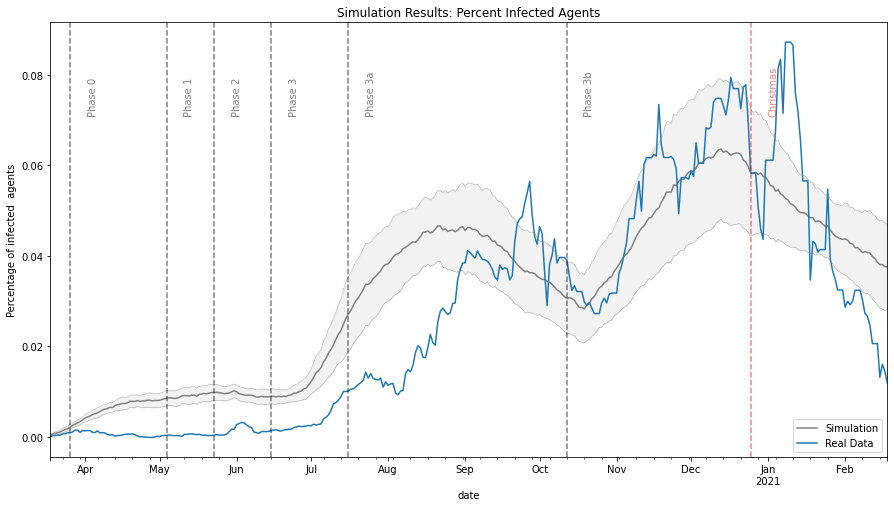

In [81]:
stat = 'infected'
fig, ax = plt.subplots(figsize=(15,8))
infected_df.average.plot(ax = ax, color=color[stat])
us_counties['percent_daily_cases'].plot(ax=ax)
ax.plot(infected_df.index, infected_df.upper, color=color[stat], linewidth=.3)
ax.plot(infected_df.index, infected_df.lower, color=color[stat], linewidth=.3) #mean curve.
ax.fill_between(infected_df.index, infected_df.lower, infected_df.upper, color=color[stat], alpha=.1) #std curves.



plt.title("Simulation Results: Percent Infected Agents")
plt.legend(['Simulation', 'Real Data'])
plt.ylabel("Percentage of infected  agents")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 0.9*np.max(infected_df['upper']), 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

CHRISTMAS = pd.to_datetime('25-12-2020')
plt.axvline(CHRISTMAS, color='red', linestyle='--', alpha=0.5)
plt.text(CHRISTMAS + delta, 0.9 * np.max(infected_df['upper']), 'Christmas', color='red', rotation=90, alpha = 0.5)

Text(2021-01-01 00:00:00, 0.0816, 'Christmas')

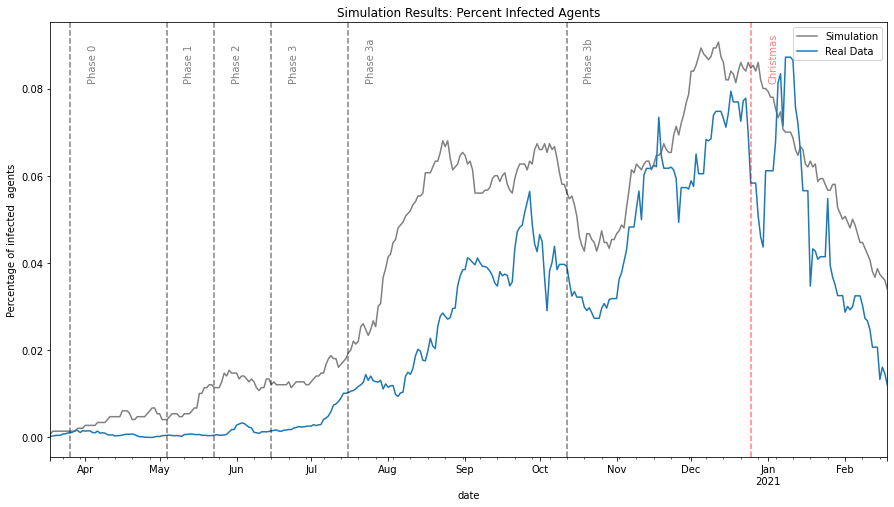

In [76]:
stat = 'infected'
fig, ax = plt.subplots(figsize=(15,8))
infected_df.average.plot(ax = ax, color=color[stat])
us_counties['percent_daily_cases'].plot(ax=ax)

plt.title("Simulation Results: Percent Infected Agents")
plt.legend(['Simulation', 'Real Data'])
plt.ylabel("Percentage of infected  agents")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 0.9*np.max(infected_df['average']), 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

CHRISTMAS = pd.to_datetime('25-12-2020')
plt.axvline(CHRISTMAS, color='red', linestyle='--', alpha=0.5)
plt.text(CHRISTMAS + delta, 0.9 * np.max(infected_df['average']), 'Christmas', color='red', rotation=90, alpha = 0.5)

___
#### Previous Single Run Using
common_parameters = SimulationParameters(
    mask_user_rate = 0.9,
    mask_efficacy = 0.6,
    imune_rate = 0.01,
    initial_infection_rate = 0.0005,
    hospitalization_capacity = 0.05,
    latency_period_shape = 3,
    latency_period_scale = 1, 
    incubation_period_shape = 6,
    incubation_period_scale = 1, 
    mild_period_duration_shape = 14,
    mild_period_duration_scale = 1,
    hospitalization_period_duration_shape = 12,
    hospitalization_period_duration_scale = 1,
    symptomatic_isolation_rate = 0.0,
    asymptomatic_contagion_probability = 0.1,
    risk_tolerance_mean = 0.2,
    risk_tolerance_stdev = 0.2,
    herding_behavior_mean = 0.7,
    herding_behavior_stdev = 0.2,
    allowed_restaurant_capacity = 0.25, #1.0, # valid values: {1.0, 0.50, 0.25}
    spreading_rate = normal_ci(2.41, 3.90, 20)
)

sc = 10

population_size = 1500
simulation_cycles = num_days # days
seed = 31415
np.random.seed(seed)

params = copy.deepcopy(common_parameters)




greene_demographics = {
    'total_population': 293086,
    'age_distribution':{
        4: 6.0,
        9: 5.7,
        14: 5.8,
        19: 6.5,
        24: 10.6,
        34: 14.1,
        44: 11.7,
        54: 11.5,
        59: 6.0,
        64: 6.0,
        74: 8.9,
        84: 5.0,
        100: 2.1
    },
    #'work_classes':{
    #    'Retail': 12.7,
    #}
}






seeds = [14568, 31221, 63168, 76414, 65369, 15407,  6812, 85182, 17096,
         50499,  5681, 24521, 34752, 91576, 91228, 69453,  2126, 83567,
         1565, 14436]

Text(2021-01-01 00:00:00, nan, 'Christmas')

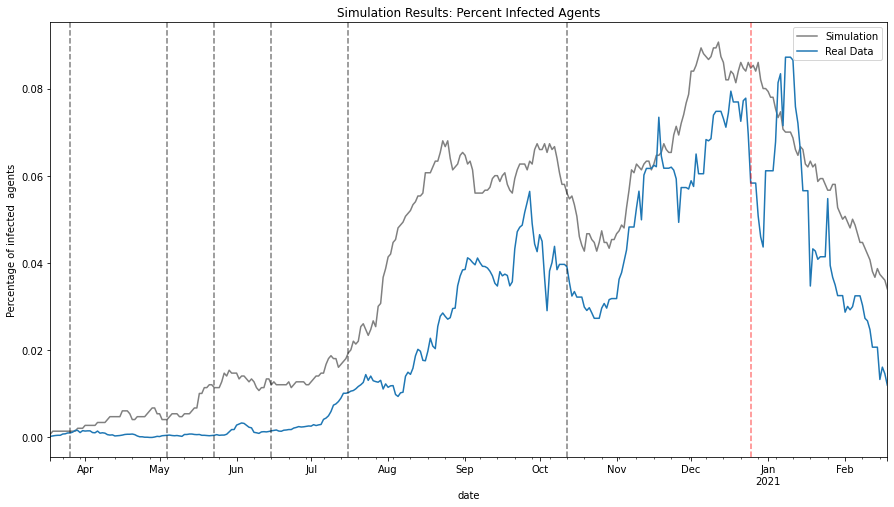

In [75]:
stat = 'infected'
fig, ax = plt.subplots(figsize=(15,8))
infected_df.average.plot(ax = ax, color=color[stat])
us_counties['percent_daily_cases'].plot(ax=ax)
ax.plot(infected_df.index, infected_df.upper, color=color[stat], linewidth=.3)
ax.plot(infected_df.index, infected_df.lower, color=color[stat], linewidth=.3) #mean curve.
ax.fill_between(infected_df.index, infected_df.lower, infected_df.upper, color=color[stat], alpha=.1) #std curves.



plt.title("Simulation Results: Percent Infected Agents")
plt.legend(['Simulation', 'Real Data'])
plt.ylabel("Percentage of infected  agents")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 0.9*np.max(infected_df['upper']), 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

CHRISTMAS = pd.to_datetime('25-12-2020')
plt.axvline(CHRISTMAS, color='red', linestyle='--', alpha=0.5)
plt.text(CHRISTMAS + delta, 0.9 * np.max(infected_df['upper']), 'Christmas', color='red', rotation=90, alpha = 0.5)

Text(2021-01-01 00:00:00, 0.0816, 'Christmas')

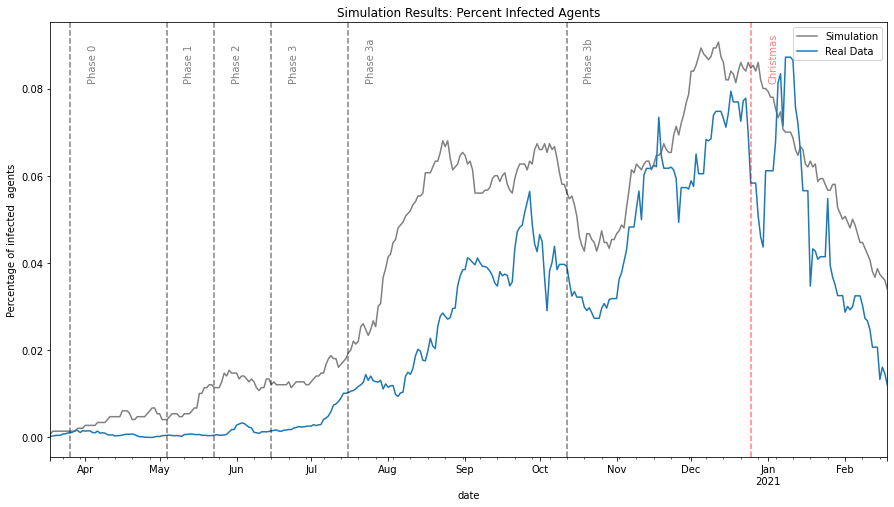

In [76]:
stat = 'infected'
fig, ax = plt.subplots(figsize=(15,8))
infected_df.average.plot(ax = ax, color=color[stat])
us_counties['percent_daily_cases'].plot(ax=ax)

plt.title("Simulation Results: Percent Infected Agents")
plt.legend(['Simulation', 'Real Data'])
plt.ylabel("Percentage of infected  agents")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 0.9*np.max(infected_df['average']), 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

CHRISTMAS = pd.to_datetime('25-12-2020')
plt.axvline(CHRISTMAS, color='red', linestyle='--', alpha=0.5)
plt.text(CHRISTMAS + delta, 0.9 * np.max(infected_df['average']), 'Christmas', color='red', rotation=90, alpha = 0.5)

___

In [23]:
simulation_df = pd.DataFrame({'susceptible': statistics.susceptible,
    'infected': statistics.infected,
    'hospitalization': statistics.hospitalization,
    'recovered': statistics.recovered,
    'death': statistics.death,
    'icu': statistics.icu})

simulation_df.index = us_counties.index

dates_df

,date,phase,num_days
0,2020-03-26,0,14
1,2020-05-04,1,53
2,2020-05-23,2,72
3,2020-06-15,3,95
4,2020-07-16,3a,126
5,2020-10-12,3b,214


Text(2021-01-01 00:00:00, 0.0882, 'Christmas')

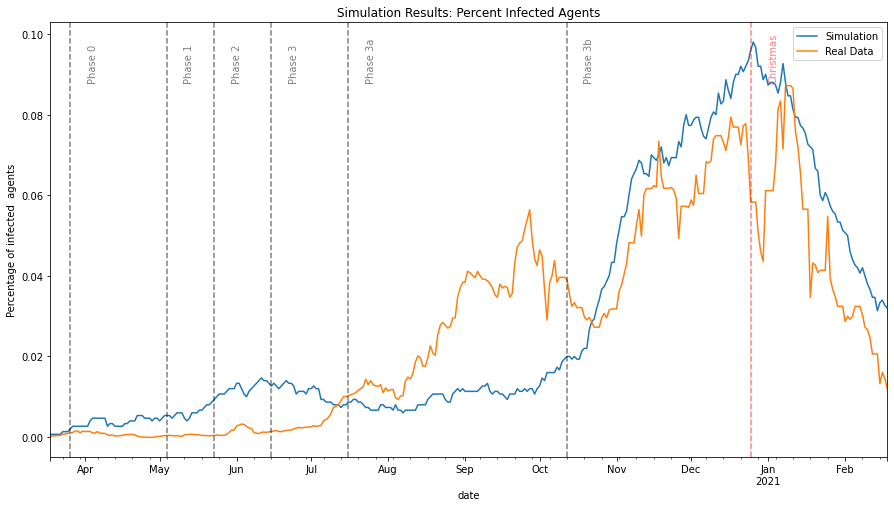

In [24]:
simulation_df['infected'].plot(figsize=(15, 8))
us_counties['percent_daily_cases'].plot()
plt.title("Simulation Results: Percent Infected Agents")
plt.legend(['Simulation', 'Real Data'])
plt.ylabel("Percentage of infected  agents")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 0.9*np.max(simulation_df['infected']), 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

CHRISTMAS = pd.to_datetime('25-12-2020')
plt.axvline(CHRISTMAS, color='red', linestyle='--', alpha=0.5)
plt.text(CHRISTMAS + delta, 0.9 * np.max(simulation_df['infected']), 'Christmas', color='red', rotation=90, alpha = 0.5)

___

___

___

___

Before changing HOSPITAL workers proportion to 0.001

In [ ]:
listeners = [
    ["AddPolicy", SocialPolicy.LOCKDOWN_RETAIL, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_FACTORY, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_OFFICE, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_HOUSEBOUND, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_HIGH_SCHOOL, START],
    
    ["RemovePolicy", SocialPolicy.LOCKDOWN_RETAIL, PHASE_3],
    
    ["RemovePolicy", SocialPolicy.LOCKDOWN_HOUSEBOUND, PHASE_3a],
    
    ["RemovePolicy", SocialPolicy.LOCKDOWN_OFFICE, PHASE_3b],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL, PHASE_3b],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL, PHASE_3b],
]

In [81]:
dates_df

,date,phase,num_days
0,2020-03-26,0,14
1,2020-05-04,1,53
2,2020-05-23,2,72
3,2020-06-15,3,95
4,2020-07-16,3a,126
5,2020-10-12,3b,214


Text(2021-01-01 00:00:00, 0.0876, 'Christmas')

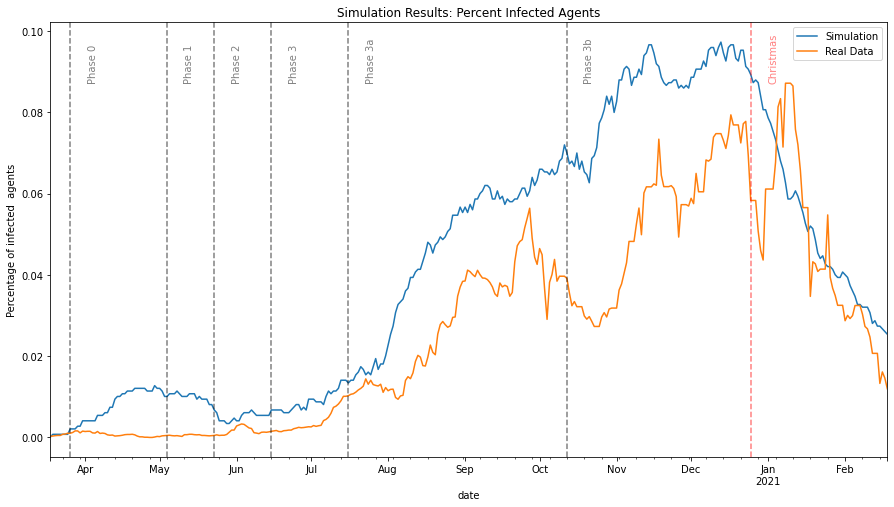

In [54]:
simulation_df['infected'].plot(figsize=(15, 8))
us_counties['percent_daily_cases'].plot()
plt.title("Simulation Results: Percent Infected Agents")
plt.legend(['Simulation', 'Real Data'])
plt.ylabel("Percentage of infected  agents")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 0.9*np.max(simulation_df['infected']), 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

CHRISTMAS = pd.to_datetime('25-12-2020')
plt.axvline(CHRISTMAS, color='red', linestyle='--', alpha=0.5)
plt.text(CHRISTMAS + delta, 0.9 * np.max(simulation_df['infected']), 'Christmas', color='red', rotation=90, alpha = 0.5)

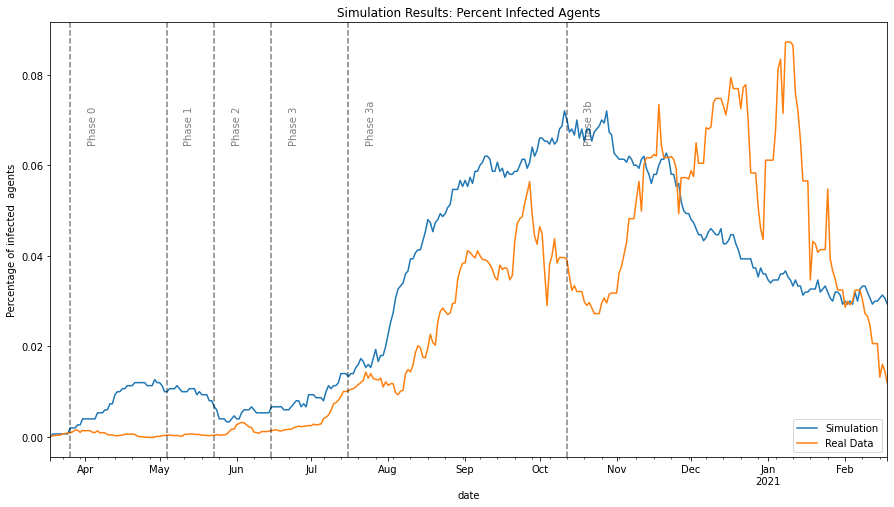

In [42]:
simulation_df['infected'].plot(figsize=(15, 8))
us_counties['percent_daily_cases'].plot()
plt.title("Simulation Results: Percent Infected Agents")
plt.legend(['Simulation', 'Real Data'])
plt.ylabel("Percentage of infected  agents")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 0.9*np.max(simulation_df['infected']), 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

___

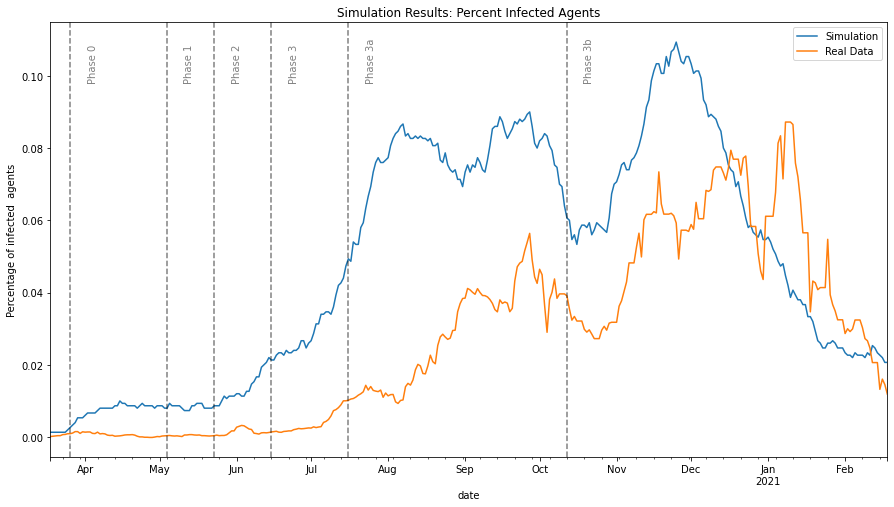

In [58]:
simulation_df['infected'].plot(figsize=(15, 8))
us_counties['percent_daily_cases'].plot()
plt.title("Simulation Results: Percent Infected Agents")
plt.legend(['Simulation', 'Real Data'])
plt.ylabel("Percentage of infected  agents")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 0.9*np.max(simulation_df['infected']), 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

____

In [ ]:
listeners = [
    ["AddPolicy", SocialPolicy.LOCKDOWN_ALL, 1],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_RETAIL, 95],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_FACTORY, 95],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL, 95],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL, 95],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_HIGH_SCHOOL, 95],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_ALL, 214],
]

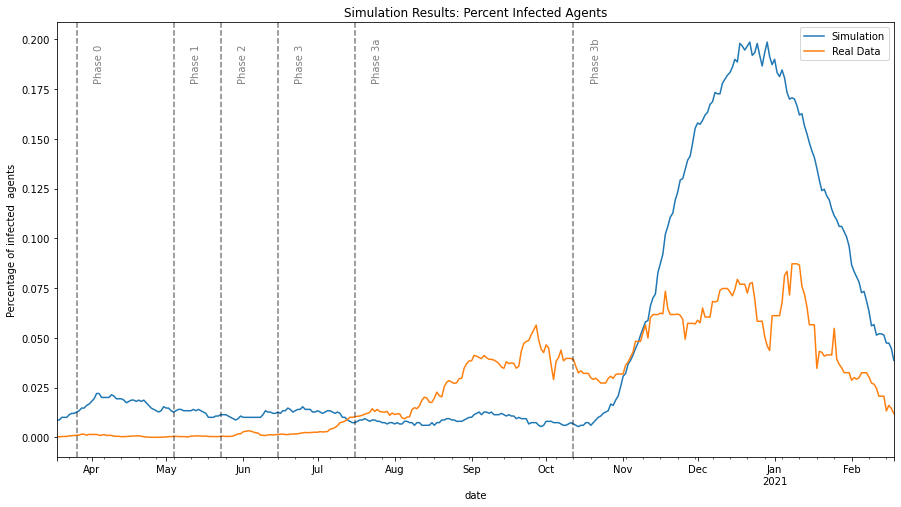

In [91]:
simulation_df['infected'].plot(figsize=(15, 8))
us_counties['percent_daily_cases'].plot()
plt.title("Simulation Results: Percent Infected Agents")
plt.legend(['Simulation', 'Real Data'])
plt.ylabel("Percentage of infected  agents")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 0.9*np.max(simulation_df['infected']), 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

In [98]:
4/greene_population

1.3647871273278151e-05

In [93]:
us_counties.head()

,cases,deaths,daily_cases,mean_daily_cases,percent_daily_cases
date,,,,,
2020-03-18,4,0.0,0,0.428571,0.00015
2020-03-19,6,0.0,2,0.714286,0.00024
2020-03-20,8,0.0,2,1.000000,0.00034
2020-03-21,10,0.0,2,1.142857,0.00039
2020-03-22,10,0.0,0,1.142857,0.00039


____

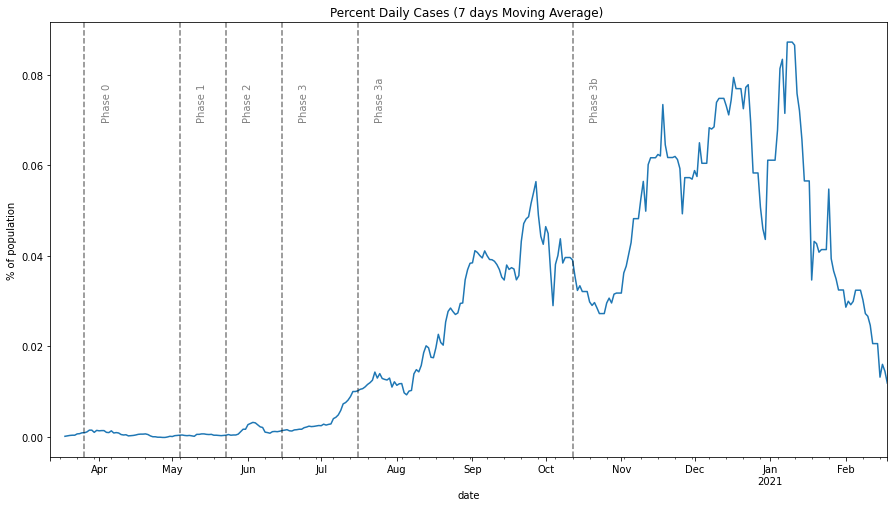

In [79]:
us_counties['percent_daily_cases'].plot(figsize=(15, 8))
plt.title("Percent Daily Cases (7 days Moving Average) ")
plt.ylabel("% of population")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 0.07, 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

In [77]:
simulation_df.head()

,susceptible,infected,hospitalization,recovered,death,icu
0,0.979333,0.008333,0.0,0.0,0.0,0.0
1,0.978667,0.009000,0.0,0.0,0.0,0.0
2,0.978000,0.009667,0.0,0.0,0.0,0.0
3,0.978000,0.009667,0.0,0.0,0.0,0.0
4,0.976667,0.011000,0.0,0.0,0.0,0.0


Pros dados de casos de covid que obtive do NYTimes (que batem com os do site de Springfield), fiz esse gráfico abaixo. Considerei a média móvel (7 dias) do número de casos e dividi pela população total de Greene (293,086). Assim tenho número de infectados de acordo com percentual da  população, o que ajuda porque até então estou rodando simulações com 1000 agentes pra ser mais rápido já que toda hora mudo algo. Ainda assim acho que a população real é grande demais pra simulação, então seria melhor manter tudo em termos relativos mesmo.

Outra coisa que fiz foi colocar linhas tracejadas em cada data de mudança de fase de reabertura pra ter ideia de quais políticas mais influenciaram a curva e quanto. 

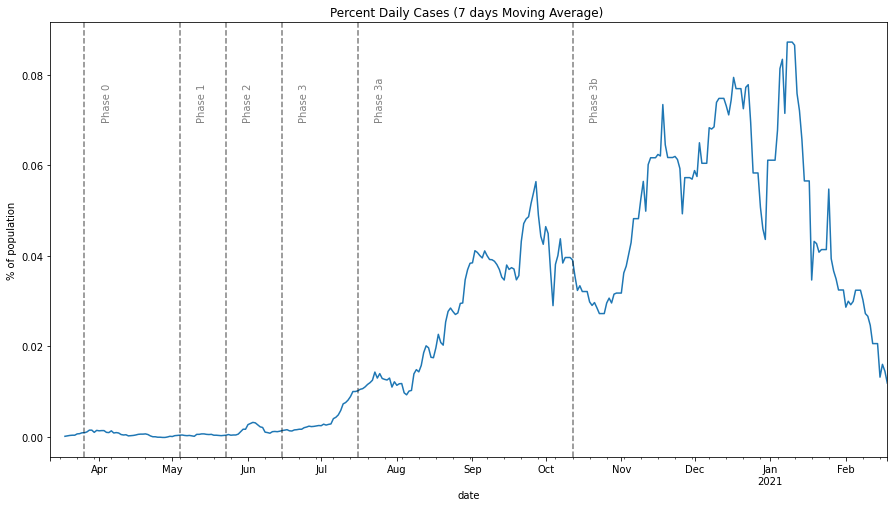

In [94]:
us_counties['percent_daily_cases'].plot(figsize=(15, 8))
plt.title("Percent Daily Cases (7 days Moving Average) ")
plt.ylabel("% of population")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 0.07, 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

2020-03-26 00:00:00
2020-05-04 00:00:00
2020-05-23 00:00:00
2020-06-15 00:00:00
2020-07-16 00:00:00
2020-10-12 00:00:00


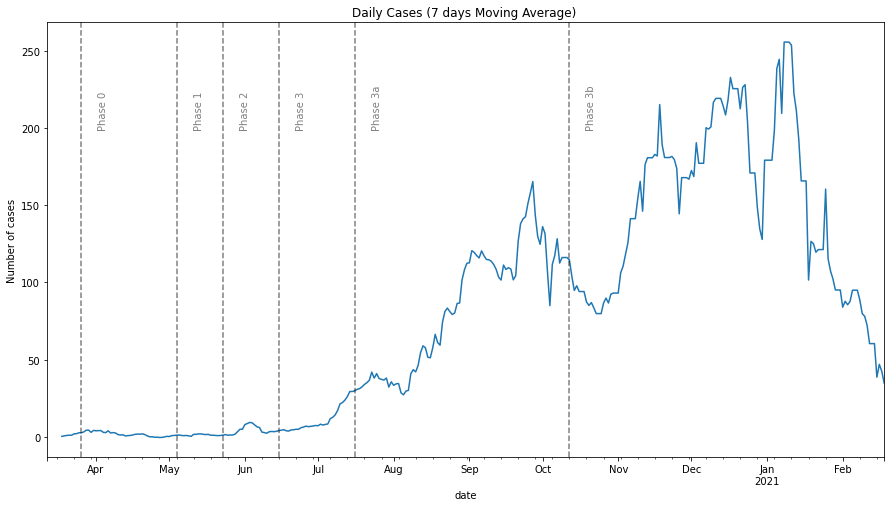

In [106]:
us_counties.mean_daily_cases.plot(figsize=(15, 8))
plt.title("Daily Cases (7 days Moving Average) ")
plt.ylabel("Number of cases")
for i, phase in dates_df[[0, 'phase']].iterrows():
    print(phase[0])
    plt.axvline(phase[0], color='k', linestyle='--', alpha=0.5)
    plt.text(phase[0] + delta, 200, 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

___

# Default parameters. Unless explicitly overriden, these values are used in all scenarios
common_parameters = SimulationParameters(
    mask_user_rate = 0.0,
    mask_efficacy = 0.0,
    imune_rate = 0.01,
    initial_infection_rate = 0.01,
    hospitalization_capacity = 0.05,
    latency_period_shape = 3,
    latency_period_scale = 1, 
    incubation_period_shape = 6,
    incubation_period_scale = 1, 
    mild_period_duration_shape = 14,
    mild_period_duration_scale = 1,
    hospitalization_period_duration_shape = 12,
    hospitalization_period_duration_scale = 1,
    symptomatic_isolation_rate = 0.0,
    asymptomatic_contagion_probability = 0.1,
    risk_tolerance_mean = 0.7,
    risk_tolerance_stdev = 0.2,
    herding_behavior_mean = 0.7,
    herding_behavior_stdev = 0.2,
    allowed_restaurant_capacity = 1.0, # valid values: {1.0, 0.50, 0.25}
    spreading_rate = normal_ci(2.41, 3.90, 20)
)

# Simulation setup
population_size = 30086

simulation_cycles = 100 # days
seed = 31415
np.random.seed(seed)
scenario = {}

sc = 3
params = copy.deepcopy(common_parameters)
params.params['social_policies'] = [
    SocialPolicy.LOCKDOWN_OFFICE,
    SocialPolicy.LOCKDOWN_FACTORY,
    SocialPolicy.LOCKDOWN_RETAIL,
    SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL,
    SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL,
    SocialPolicy.LOCKDOWN_HIGH_SCHOOL,
    SocialPolicy.SOCIAL_DISTANCING
]

set_parameters(params)
model = CovidModel()
np.random.seed(seed)
setup_city_layout(model, population_size)
model.add_listener(RemovePolicy(model, SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL, 30))
model.add_listener(RemovePolicy(model, SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL, 60))
model.add_listener(RemovePolicy(model, SocialPolicy.LOCKDOWN_HIGH_SCHOOL, 90))

model.reset_randomizer(seed)
statistics = BasicStatistics(model)
model.add_listener(statistics)
for i in range(simulation_cycles):
    model.step()
statistics.export_chart("scenario" + str(sc) + ".png")
statistics.export_csv("scenario" + str(sc) + ".csv")